In [1]:
! pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.9 MB/s eta 0:00:00


### Import libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
root_path = "/content/drive/MyDrive/Deep_learning_course/Video_processing/"
data_path = "/content/data/"

In [4]:
import os
import torch
from torcheval.metrics.functional import multiclass_accuracy, multiclass_auroc, multiclass_recall
import torch.nn as nn
from torch.optim import Adam, AdamW
from sklearn.model_selection import train_test_split
import pickle

In [5]:
import sys
sys.path.append(root_path + "src")
from dataloader import load_train_eval_data
from video_sequence_model import VideoSequenceModel
from fit_func import FitTrainEval

In [6]:
external_data_path = os.path.join(root_path, "data/", "UFC-5.zip")
local_data_path = data_path
!unzip -q $external_data_path -d $local_data_path

### Load Data

In [7]:
# data parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_folder_path = os.path.join(data_path, "UFC-5/")
batch_size = 30
num_workers = 8
resize_size = 256
nframes = 10
# model parameters
embedding_size = 300
lstm_hidden = 300
lstm_layers = 5
num_classes = 5
model_load = "seqvideo_4.pkl"
model_save = "seqvideo_5.pkl"
model_load = os.path.join(root_path, "models/", model_load)
model_path = os.path.join(root_path, "models/", model_save)
metrics = [multiclass_accuracy]
EPOCHS = 500

In [8]:
data_train, data_eval = load_train_eval_data(
    path_to_data=data_folder_path,
    batch_size=batch_size,
    resize=resize_size,
    nframes=nframes,
    workers=num_workers,
    pin_memory_device=device
)

### Train models

In [9]:
model = VideoSequenceModel(
    sequence_length=nframes,
    embedding_size=embedding_size,
    lstm_hidden=lstm_hidden,
    lstm_layers=lstm_layers,
    num_classes=num_classes
)
# model.load_state_dict(torch.load(model_load))
model = model.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 76.1MB/s]


In [10]:
def create_layers():

    layers = [i[0] for i in model.named_parameters() if i[0].find("classifier") > -1]

    layers += [
      "lstm.weight_ih_l0",
      "lstm.weight_hh_l0",
      "lstm.bias_ih_l0",
      "lstm.bias_hh_l0",
      "lstm.weight_ih_l1",
      "lstm.weight_hh_l1",
      "lstm.bias_ih_l1",
      "lstm.bias_hh_l1",
      "fc.weight",
      "fc.bias"
    ]

    return layers

In [11]:
layers = create_layers()

In [12]:
def freeze_layers(model, layers):
    last_layer_name = layers

    for name, param in model.named_parameters():
        if name not in last_layer_name:
            param.requires_grad = False

In [13]:
freeze_layers(model, layers)

In [16]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=5e-5)

In [17]:
optimization = FitTrainEval(
    model=model,
    loss=loss_fn,
    optimizer=optimizer,
    metrics=metrics,
    path_save=model_path,
    device=device
)

In [ ]:
trained = optimization.fit_train_eval(
    data_train=data_train,
    data_eval=data_eval,
    epochs=EPOCHS,
)

### Check metrics

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
state = torch.load(model_path)

In [ ]:
state.keys()

dict_keys(['model', 'loss', 'optimizer', 'loss_history', 'metric_history', 'val_loss_history', 'val_metric_history'])

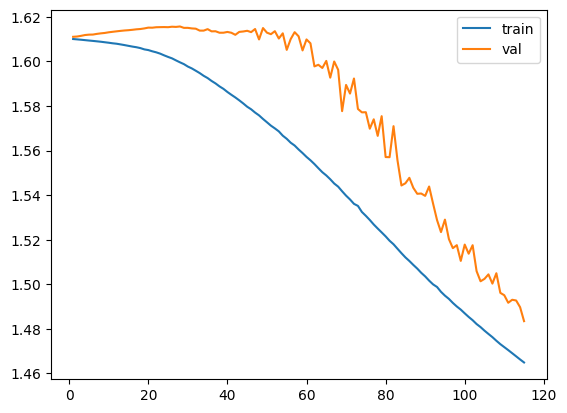

In [ ]:
plt.plot(state["loss_history"], label="train")
plt.plot(state["val_loss_history"], label="val")
plt.legend()

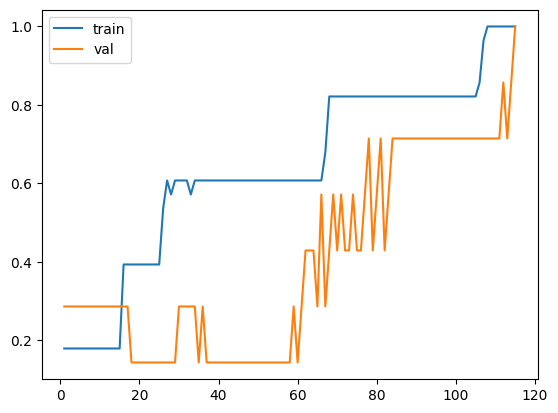

In [ ]:
plt.plot(state["metric_history"]["multiclass_accuracy"], label="train")
plt.plot(state["val_metric_history"]["multiclass_accuracy"], label="val")
plt.legend()